# BERTopic

## Introduction

BERTopiv is an unsupervised technique in the space of topic modeling leveraging BERT. Broadly, given a bunch of texts, and the number of desired topics as an input, it categories each text into one or more topics 

The basic BERTopic, just like other topic models ,  is not a supervised model, the topics don't make any natural sense beforehand. For example, if you want to separate a bunch of documents into sports, politics and science topics, what you can do is specify the no of topics as 3,
and BERTopic comes back and says that document 1 has 0.7 topic1, 0.2 topic 2, 0.1 topic 3;

document 2 has 0.5 topic 1, 0.5 topic 2 and 0 topic 3 for example

What topic1, 2, 3 correspond to from a domain standpoint - whether topic 1 is sports, or topic 1 is a mixture of sports and politics is something a human expert has to decide

However, other variants of BERTopic exist which can be used in a kind of supervised setting

## Method

BERTopic uses a sequence of 6 steps to get topic representations. The last step (Finetune representations) is optional

These 6 steps are 

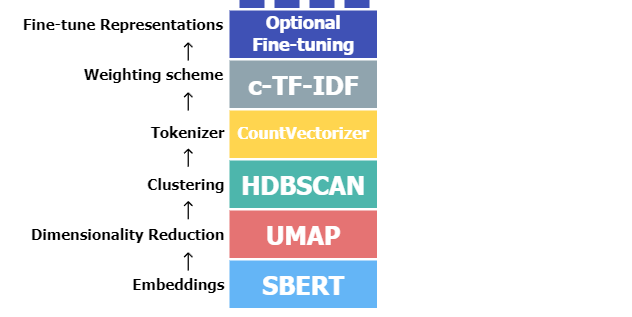


Each of the 6 steps above is modular, and can be swapped, For example, instead of UMAP for dimensionality reduction step, PCA can be used, etc

Below are some options of possible choices at each step

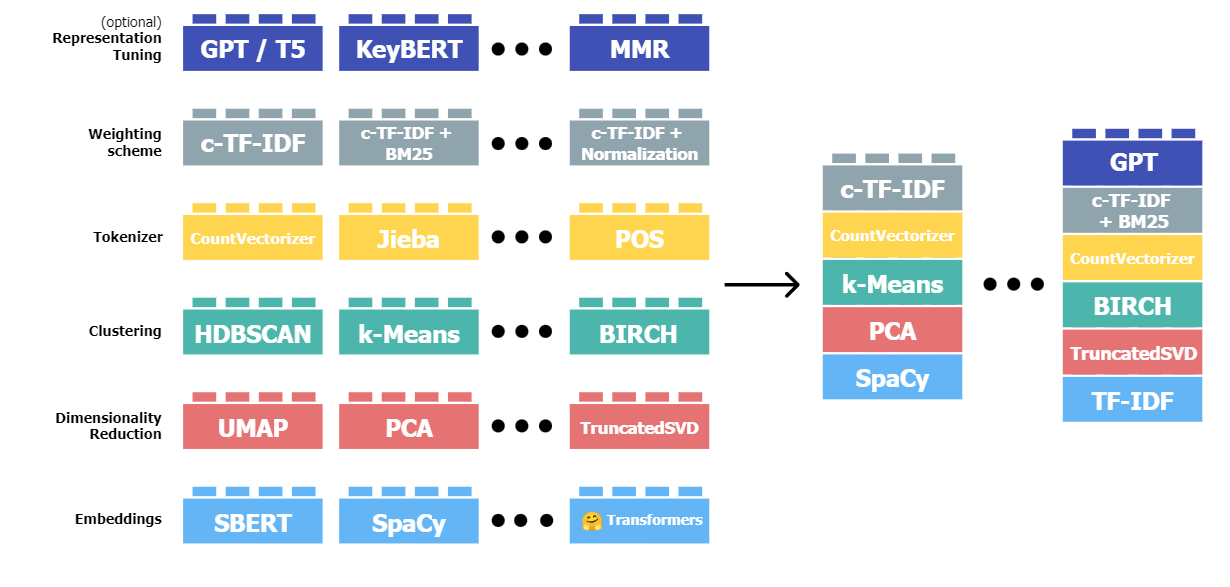

In some more detail

1) Step 1 embeds documents - Here sentence transformers is the most popular choice, but other embeddings such as spacy embeddings, etc can be used

This step creates a numerical representation of the document/text

A common sentence transformer model for embedding english is "all-MiniLM-L6-v2"
A common sentence transformer model for multilingual data embedding is "paraphrase-multilingual-MiniLM-L12-v2"

2) Step 2  reduces the N dimensional embedding to a lower dimension, This is important because clustering, the subsequent step works better at lower dimensions.
PCA can be used (a linear dimensionality reduction technique), but UMAP can keep some of a dataset's local and global structure when reducing its dimensionality

TODO : Read up on UMAP

3) Once embeddings are reduced to lower dimension, we used clustering. K-means can be used, but a density based clustering technique such as HDBSCAN works well as it can find clusters of different shapes and has the nice feature of identifying outliers where possible ie documents are not forced into a cluster where they might not belong unlike KMeans

4) Tokenizer/Bag of Words

In this step, all documents belong to a cluster are collapsed into a single long document representing that cluster. As a result , you kind of get K "documents", for each of the K clusters identified in the previous step

Now , we just count the number of words in each of the K "documents" to get a Bag of words based representation for each cluster. L1 normalized to account for the fact that each "document" might have a different length

BOW makes no assumption on the expected cluster structure, so its a good choice in practice

5) Topic Representation - cTF-IDF

On top of the BOW from the prev step on each of the K long documents, we run a TF-IDF where the document is the long document.

It's really called cTF-IDF because the TF-IDF is not on the original documents, but on the new long "documents", so called a class based TF-IDF

At the end of this step, we get which words are important for each of the K clusters/topics, which is exactly what we want !!

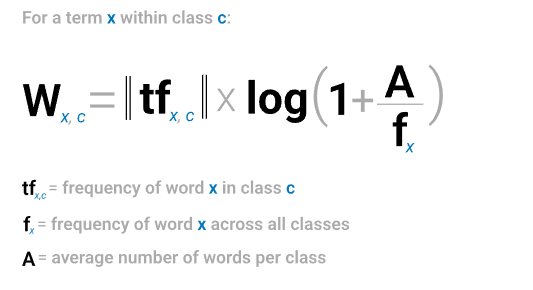

6) Fine-tune Topic representation (Optional)

The previous Topic representation step itself gives you the list of most important words per topic/cluster. 
However, we can finetune these further using cutting ledge language models to make the representations still better

ie We can pass the candidate topics and documents belonging to each candidate topic from step 5 to a GPT-4 like model to finetune further and get better descriptions of topics, more accurate words, etc


All of these are implemented

MaximalMarginalRelevance
PartOfSpeech
KeyBERTInspired
ZeroShotClassification
TextGeneration
Cohere
OpenAI
LangChain


## Implementation

In [ ]:
!pip uninstall bertopic

In [1]:
import hdbscan

In [3]:
from bertopic import BERTopic

In [4]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
 


### Load the dataset

This is the ENRON emails dataset, containing ~500K emails which we want to do topic modeling on

In [26]:
import pandas
df = pandas.read_csv("../../data/emails.csv")
data = df['content'].sample(frac=0.001, random_state=42 ).values

In [27]:
len(data)

517

In [35]:
topic_model = BERTopic()

Under the hood, topic_model has these steps

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer


# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
representation_model = KeyBERTInspired()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic represenations
)


Note : What does fit mean in this context ? The 2 components - umap model and hdbscan model are fit to the data

The embedding model (for example) sentence transformers is NOT fit to the data in this library, It just applies pretrained embedding models to the data to get embeddings - just get the transform step

UMAP (for dimensionality reduction) and HDBSCAN (for clustering) on the other hand, are fit to the data

In [37]:
topics, probs = topic_model.fit_transform(data)

In [30]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3,-1_paloxls_gc010522xls_reportxls_1127,"[paloxls, gc010522xls, reportxls, 1127, httpex...","[ - GC010522.xls , <<Palo.xls>> Due to Techni..."
1,0,500,0_the_to_and_of,"[the, to, and, of, in, for, is, you, on, that]",[got your message last night. What is up? Be...
2,1,14,1_dbcaps97data_database_final_hourahead,"[dbcaps97data, database, final, hourahead, ali...",[Start Date: 4/29/01; HourAhead hour: 15; No ...


In [33]:
topic_model.get_topic(0)

[('the', 0.09442702078861223),
 ('to', 0.08009661444534379),
 ('and', 0.05873662611154682),
 ('of', 0.054293407061040626),
 ('in', 0.04315149039050795),
 ('for', 0.039590386138399394),
 ('is', 0.034238627051323946),
 ('you', 0.03385508098362485),
 ('on', 0.03375230368923801),
 ('that', 0.03199172759622478)]

In [36]:
topic_model.transform(data)

ValueError: This BERTopic instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)

## References

1) https://maartengr.github.io/BERTopic/
2) https://maartengr.github.io/BERTopic/algorithm/algorithm.html
3) https://arxiv.org/pdf/2203.05794.pdf